In [ ]:
# %pip install wandb

In [1]:
import os
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.autograd as autograd
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import wandb

# Параметры модели и обучения

In [2]:
model_name = 'panda64'
version = 'v2'

results_dir = f'results_{model_name}_{version}'

In [3]:
from dataset import ArchDataset, GT_NEGATIVE_PATHS, GT_POSITIVE_PATHS, GT_NEGATIVE_COORDS, GT_POSITIVE_COORDS
from train_wgan import compute_gradient_penalty, train_wgangp
from model_4_panda_064 import PandaGenerator, PandaDiscriminator

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
params = {
    'batch_size': 256,
    'channels': 3,
    'img_size': 64,
    'latent_dim': 512,
    'lr': 0.0001,
    'b1': 0.5,
    'b2': 0.999,
    'weight_decay': 0,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 100,
}

# Датасет

In [6]:
transform_crop_64 = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
train_dataset = ArchDataset(
    img_paths=GT_NEGATIVE_PATHS, 
    coords=GT_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GT_POSITIVE_PATHS, 
    coords=GT_POSITIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [8]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 547 batches
anomalies: 163 images, 1 batches


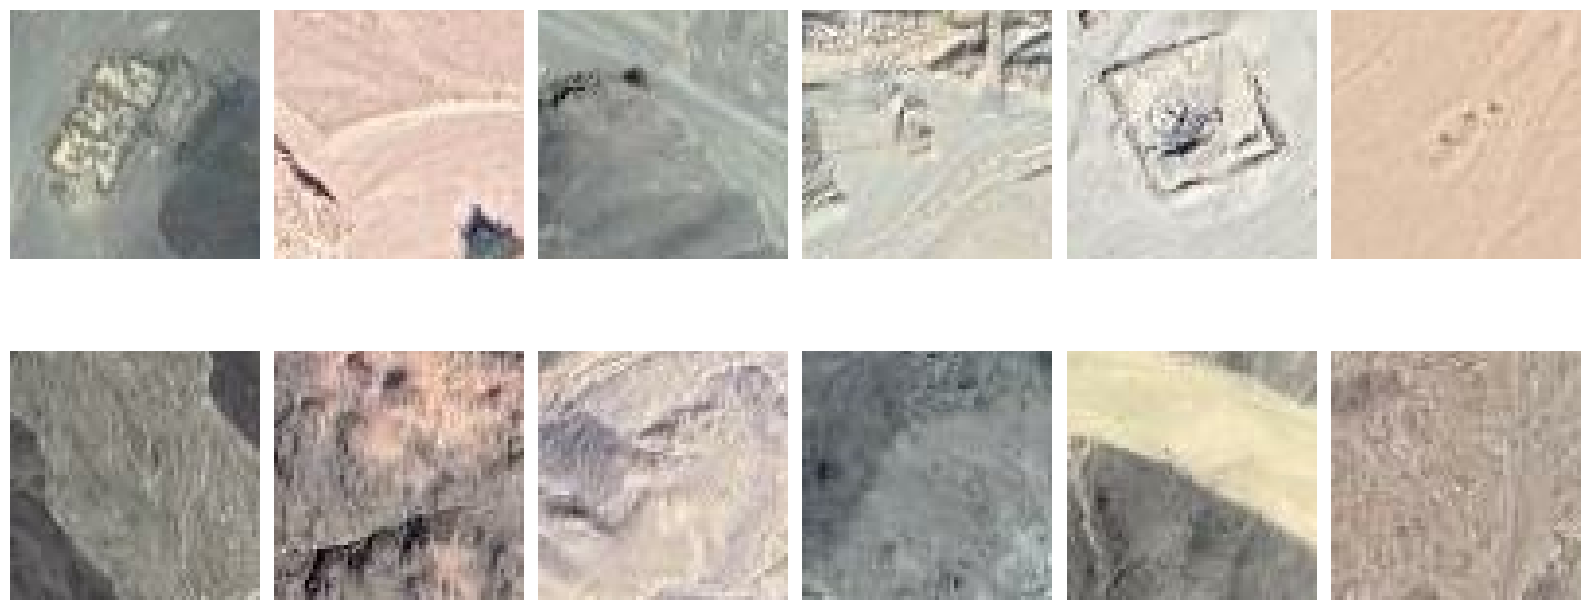

In [9]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow((anomalies_dataset[i][0].permute(1, 2, 0) + 1) / 2)
    axs[1, i].imshow((train_dataset[i][0].permute(1, 2, 0) + 1) / 2)
fig.tight_layout()
fig.show()

# Создание модели

In [10]:
def params_count(model):
    n_params = 0
    for n, p in model.named_parameters():
        n_params += np.prod(p.shape)
    return n_params

In [11]:
generator = PandaGenerator(params)
discriminator = PandaDiscriminator(params)

In [12]:
print(f'{params_count(generator)=}')
print(f'{params_count(discriminator)=}')

params_count(generator)=16182065
params_count(discriminator)=14347911


# Обучение GAN

In [13]:
import wandb

wandb.login(key='514eb1383ebf19dfe33c9834438026c917300873')
wandb.init( project=f'arch_{model_name}', name=f'gan_{model_name}_{version}')

wandb: Currently logged in as: nadiaroschina. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: wandb version 0.17.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.6
wandb: Run data is saved locally in /home/jupyter/datasphere/archaeology-project/fanogan_training/train_generator_discriminator/wandb/run-20240910_214628-wwgyotuj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run gan_panda64_v2
wandb: ⭐️ View project at https://wandb.ai/nadiaroschina/arch_panda64
wandb: 🚀 View run at https://wandb.ai/nadiaroschina/arch_panda64/runs/wwgyotuj


In [ ]:
with tqdm(
    total=(params['n_epochs'] * len(train_loader) // params['n_critic']), 
    desc=f"[Epoch ?] [Batch ?] [D loss: ?] [G loss: ?]"
) as pbar:
    train_wgangp(results_dir, pbar, params, generator, discriminator, train_loader, device)

[Epoch   0/200][Batch 200/547] [D loss: 1.927380] [G loss: -0.242897]:   0%|          | 41/21880 [03:41<33:05:02,  5.45s/it]

In [ ]:
# torch.save(generator.state_dict(), f'{results_dir}/generator')
# torch.save(discriminator.state_dict(), f'{results_dir}/discriminator')